In [1]:
!git clone https://github.com/facebookresearch/ImageBind.git
%cd ImageBind


Cloning into 'ImageBind'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 146 (delta 60), reused 39 (delta 39), pack-reused 58 (from 1)
Receiving objects: 100% (146/146), 2.64 MiB | 14.64 MiB/s, done.
Resolving deltas: 100% (68/68), done.
/content/ImageBind


In [2]:
!pip install .

Processing /content/ImageBind
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/facebookresearch/pytorchvideo.git (to revision 28fe037d212663c6a24f373b94cc5d478c8c1a1d) to /tmp/pip-install-eohwyk42/pytorchvideo_cba62703a48e461d8c2a907408ac5f98
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorchvideo.git /tmp/pip-install-eohwyk42/pytorchvideo_cba62703a48e461d8c2a907408ac5f98
  Running command git rev-parse -q --verify 'sha^28fe037d212663c6a24f373b94cc5d478c8c1a1d'
  Running command git fetch -q https://github.com/facebookresearch/pytorchvideo.git 28fe037d212663c6a24f373b94cc5d478c8c1a1d
  Running command git checkout -q 28fe037d212663c6a24f373b94cc5d478c8c1a1d
  Resolved https://github.com/facebookresearch/pytorchvideo.git to commit 28fe037d212663c6a24f373b94cc5d478c8c1a1d
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.p

In [3]:
!cd ..
!pip show imagebind
!pip install umap-learn

Name: imagebind
Version: 0.1.0
Summary: A brief description of the package
Home-page: https://github.com/facebookresearch/ImageBind
Author: 
Author-email: 
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: cartopy, einops, eva-decord, ftfy, fvcore, iopath, matplotlib, mayavi, numpy, pytorchvideo, regex, timm, torch, torchaudio, torchvision, types-regex
Required-by: 
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.9 MB/s eta 0:00:00


In [4]:
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType # Import ModalityType from the correct location
from imagebind import data

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


In [5]:
# Clone the ESC-50 dataset
!git clone https://github.com/karolpiczak/ESC-50.git


Cloning into 'ESC-50'...
remote: Enumerating objects: 4199, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 4199 (delta 40), reused 38 (delta 18), pack-reused 4136 (from 1)
Receiving objects: 100% (4199/4199), 878.79 MiB | 49.28 MiB/s, done.
Resolving deltas: 100% (287/287), done.
Updating files: 100% (2011/2011), done.


In [6]:
# Import necessary libraries
import os
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm

In [7]:
# Ensure you have a GPU runtime enabled
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
# Check dataset directory
# Set paths to your dataset
dataset_path = "/content/ImageBind/ESC-50/audio"
meta_path = "/content/ImageBind/ESC-50/meta/esc50.csv"

In [12]:
# Load metadata
import pandas as pd
metadata = pd.read_csv(meta_path)
print(metadata.head())

            filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A


In [13]:
# Function to load an audio file
def load_audio(file_path):
    waveform, sample_rate = torchaudio.load(file_path)
    return waveform, sample_rate

In [14]:
# Load a sample audio file
sample_audio_path = os.path.join(dataset_path, metadata.iloc[0]['filename'])
waveform, sample_rate = load_audio(sample_audio_path)

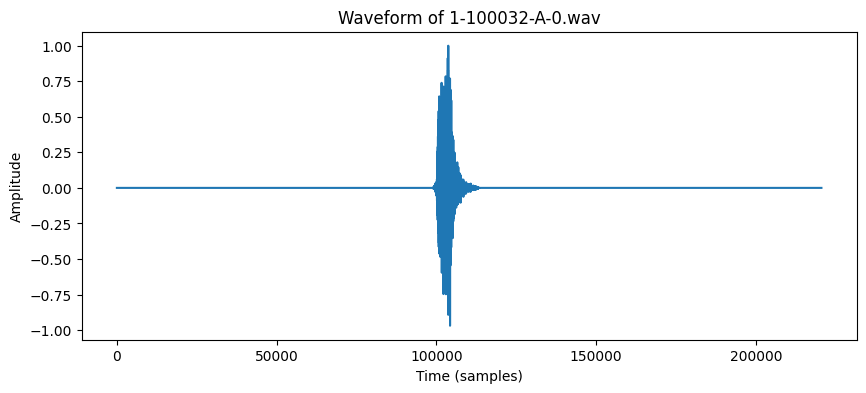

In [15]:
# Visualize the waveform
plt.figure(figsize=(10, 4))
plt.plot(waveform.t().numpy())
plt.title(f"Waveform of {metadata.iloc[0]['filename']}")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.show()

In [16]:
def load_model():
    """Initialize and return the ImageBind model"""
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    model = imagebind_model.imagebind_huge(pretrained=True)
    model.eval()
    model.to(device)
    return model, device


In [55]:
# Load metadata
print("Loading metadata...")
metadata = pd.read_csv(meta_path)
labels = {'dog':0, 'hen':1, 'sheep':2, 'frog':3, 'cow':4}
filtered_df = metadata[metadata['category'].isin(labels.keys())]
print(filtered_df)

audio_files = filtered_df['filename'].tolist()
audio_dir = "/content/ImageBind/ESC-50/audio"
audio_files = [os.path.join(audio_dir, filename) for filename in audio_files]

categories = filtered_df['category'].tolist()
for l in labels.keys():
  print(f"There are {categories.count(l)} of {l}")

Loading metadata...
              filename  fold  target category  esc10  src_file take
0     1-100032-A-0.wav     1       0      dog   True    100032    A
14    1-110389-A-0.wav     1       0      dog   True    110389    A
29    1-121951-A-8.wav     1       8    sheep  False    121951    A
45     1-15689-A-4.wav     1       4     frog  False     15689    A
46     1-15689-B-4.wav     1       4     frog  False     15689    B
...                ...   ...     ...      ...    ...       ...  ...
1956  5-253085-B-3.wav     5       3      cow  False    253085    B
1994  5-263831-A-6.wav     5       6      hen  False    263831    A
1995  5-263831-B-6.wav     5       6      hen  False    263831    B
1998   5-61635-A-8.wav     5       8    sheep  False     61635    A
1999    5-9032-A-0.wav     5       0      dog   True      9032    A

[200 rows x 7 columns]
There are 40 of dog
There are 40 of hen
There are 40 of sheep
There are 40 of frog
There are 40 of cow


In [56]:
# Initialize model
print("Loading model...")
model, device = load_model()

# Load data
inputs = {
    ModalityType.TEXT: data.load_and_transform_text(labels.keys(), device),
    ModalityType.AUDIO: data.load_and_transform_audio_data(audio_files, device),
}

# Use autocast to reduce memory usage
# with torch.cuda.amp.autocast():
embeddings = None
with torch.no_grad():
  embeddings = model(inputs)

Loading model...


In [54]:
print(
    "Audio x Text: ",
    torch.softmax(embeddings[ModalityType.AUDIO] @ embeddings[ModalityType.TEXT].T, dim=-1),
)

record_list = pd.DataFrame(columns=labels.keys())

for tensor in torch.softmax(embeddings[ModalityType.AUDIO] @ embeddings[ModalityType.TEXT].T, dim=-1):
    record_list.loc[len(record_list)] = tensor.tolist()

record_list = record_list.fillna(0)
print(record_list)

torch.Size([200, 5])
tensor([[1.0000e+00, 1.6518e-36, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 4.7644e-44, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 7.5315e-32, 0.0000e+00, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],

In [50]:
y_true = []
y_pred = []

for c in categories:
    if c in labels.keys():
        y_true.append(labels[c])
print(y_true)

for index, row in record_list.iterrows():
    max_col_index = row.argmax()  # gets index of max value
    y_pred.append(max_col_index)

print(y_pred)

[0, 0, 2, 3, 3, 4, 3, 1, 1, 3, 3, 3, 2, 2, 4, 0, 0, 1, 1, 3, 3, 0, 2, 2, 2, 4, 0, 1, 4, 4, 1, 1, 1, 2, 4, 4, 4, 0, 2, 0, 4, 4, 4, 4, 4, 4, 2, 2, 0, 0, 0, 0, 4, 4, 0, 0, 2, 2, 2, 1, 1, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 4, 4, 4, 4, 0, 2, 2, 2, 2, 0, 4, 4, 0, 0, 4, 0, 4, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 1, 0, 1, 1, 1, 0, 4, 4, 4, 1, 1, 1, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 4, 0, 0, 0, 0, 0, 0, 0, 3, 4, 1, 1, 1, 1, 1, 1, 4, 4, 1, 1, 2, 0]
[0, 0, 2, 3, 3, 4, 3, 1, 1, 3, 3, 3, 2, 2, 4, 0, 0, 1, 1, 3, 3, 0, 2, 2, 2, 4, 0, 1, 4, 4, 1, 1, 1, 2, 4, 4, 4, 0, 2, 0, 4, 4, 4, 4, 4, 4, 2, 2, 0, 0, 0, 0, 4, 4, 0, 0, 2, 2, 2, 1, 1, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 4, 4, 4, 4, 0, 2, 2, 2, 2, 0, 4, 4, 0, 0, 4, 0, 4, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 0, 0, 0, 2, 2, 2,

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

def plot_confusion_matrix(y_true, y_pred, labels=None, normalize=True,
                         include_metrics=True, cmap='Blues', figsize=(12, 8)):
    """
    Plot a comprehensive confusion matrix with additional metrics.

    Parameters:
    -----------
    y_true : array-like
        Ground truth labels
    y_pred : array-like
        Predicted labels
    labels : list, optional
        List of labels for classes
    normalize : bool, default=True
        Whether to normalize the confusion matrix
    include_metrics : bool, default=True
        Whether to include precision, recall, and F1 scores
    cmap : str, default='Blues'
        Colormap for the confusion matrix
    figsize : tuple, default=(12, 8)
        Figure size (width, height)
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Normalize if requested
    if normalize:
        cm_plot = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2%'  # Percentage format
    else:
        cm_plot = cm
        fmt = 'd'    # Integer format

    # Create figure
    fig = plt.figure(figsize=figsize)

    # If including metrics, create subplot for confusion matrix
    if include_metrics:
        plt.subplot(1, 2, 1)

    # Plot confusion matrix
    sns.heatmap(cm_plot, annot=True, fmt=fmt, cmap=cmap,
                square=True, cbar=True,
                xticklabels=labels if labels else "auto",
                yticklabels=labels if labels else "auto")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix' + (' (Normalized)' if normalize else ''))

    plt.tight_layout()
    plt.show()

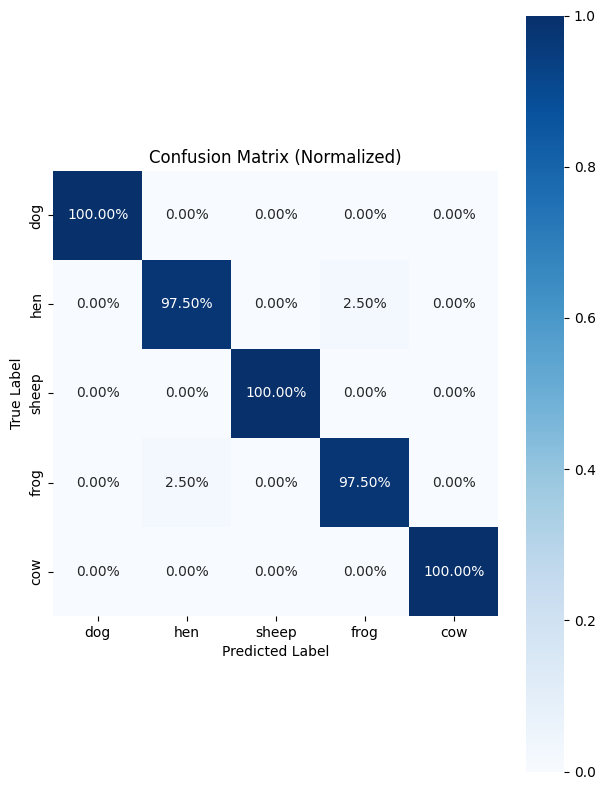

In [53]:
plot_confusion_matrix(y_true, y_pred, labels=labels.keys(), normalize=True, include_metrics=True, cmap='Blues', figsize=(12, 8))